# Initial Setup

In [1]:
import requests
import pyspark
import json
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime
import matplotlib.pyplot as plt

In [2]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Importing and Preprocessing the Data

## Allowance Events

In [3]:
gist_url = "https://gist.githubusercontent.com/DaniModak/d0cdc441bc2cab2abdc5b37e45ca5cb4/raw/13ded757082f09740a0ca351f926b74c336206ab/allowance_events"
response = requests.get(gist_url)
file_content = json.loads(response.text)

#the schema needs to be passed, otherwise the data will be corrupted.
schema = StructType([
    StructField("user", StructType([
        StructField("id", StringType(), True)
    ]), True),
    StructField("event", StructType([
        StructField("timestamp", StringType(), True),
        StructField("name", StringType(), True)
    ]), True),
    StructField("allowance", StructType([
        StructField("scheduled", StructType([
            StructField("frequency", StringType(), True),
            StructField("day", StringType(), True)
        ]), True),
        StructField("amount", IntegerType(), True)
    ]), True)
])

allowance_events = spark.createDataFrame(file_content, schema)
allowance_events = allowance_events.withColumn("user_id", col("user.id")) \
    .withColumn("event_timestamp", col("event.timestamp")) \
    .withColumn("event_name", col("event.name")) \
    .withColumn("allowance_scheduled_frequency", col("allowance.scheduled.frequency")) \
    .withColumn("allowance_scheduled_day", col("allowance.scheduled.day")) \
    .withColumn("allowance_amount", col("allowance.amount")) \
    .drop("user", "event", "allowance").dropDuplicates()

allowance_events.createOrReplaceTempView("allowance_events")

In [4]:
print(allowance_events.show())

+--------------------+-------------------+-----------------+-----------------------------+-----------------------+----------------+
|             user_id|    event_timestamp|       event_name|allowance_scheduled_frequency|allowance_scheduled_day|allowance_amount|
+--------------------+-------------------+-----------------+-----------------------------+-----------------------+----------------+
|c152c34e-1126-451...| 2024-09-21 9:37:27|allowance.created|                      monthly|              first_day|             100|
|55012a6f-f87f-476...|2024-10-04 14:35:00| allowance.edited|                       weekly|                 friday|               5|
|eb8bc59b-1ad3-4b2...|2024-10-16 21:22:35|allowance.created|                     biweekly|                tuesday|              10|
|51f8cbb2-b2fd-487...|2024-11-25 16:53:36| allowance.edited|                     biweekly|                tuesday|               5|
|1de66f8e-a97e-4c4...| 2024-11-06 8:45:36| allowance.edited|                

## Allowance Backend Table

In [5]:
gist_url = "https://gist.githubusercontent.com/DaniModak/d0cdc441bc2cab2abdc5b37e45ca5cb4/raw/13ded757082f09740a0ca351f926b74c336206ab/allowance_backend_table"
response = requests.get(gist_url)
file_content = response.text.split('\n')
headers = file_content[0].split(',')
data = [line.split(',') for line in file_content[1:]]
allowance_backend_table = spark.createDataFrame(data, headers)

In [6]:
## I use this logic to treat multiple data type at updated_at column. I found unix ints and timestamp mixed in that column.
## I could use a case when to solve it as well, but I found that way more ellegant. :)

allowance_backend_table = allowance_backend_table.withColumn("creation_date", col("creation_date").cast("int")) \
        .withColumn("updated_at_minix", col("updated_at").cast("int")) \
        .withColumn("next_payment_day", col("next_payment_day").cast("int")) \
        .withColumn("creation_date", from_unixtime("creation_date")) \
        .withColumn("updated_at_minix", from_unixtime("updated_at_minix")) \
        .withColumn("updated_at", to_timestamp("updated_at")) \
        .withColumn("updated_at", to_timestamp(coalesce(col("updated_at"), col("updated_at_minix")))).drop("updated_at_minix") \
        .filter("status == 'enabled'").dropDuplicates()

allowance_backend_table.createOrReplaceTempView("allowance_backend_table")

allowance_backend_table.show()

+--------------------+-------------------+---------+-------------+--------------------+----------------+-------+
|                uuid|      creation_date|frequency|          day|          updated_at|next_payment_day| status|
+--------------------+-------------------+---------+-------------+--------------------+----------------+-------+
|2966ceec-b14c-4ce...|2024-11-02 23:10:34|   weekly|       friday|2024-11-08 08:00:...|              15|enabled|
|cd174bb6-eeb2-48b...|2024-10-03 17:58:50|   weekly|       monday| 2024-10-03 17:58:50|               7|enabled|
|5972b8e0-4b5b-494...|2024-11-18 18:49:29|  monthly|    first_day|2024-11-18 18:58:...|               1|enabled|
|67024fd1-c2ff-4fc...|2024-11-09 14:41:12|  monthly|fifteenth_day|2024-11-24 14:51:...|              15|enabled|
|f74f401d-76ad-440...|2024-10-01 15:43:41| biweekly|       sunday|2024-11-10 08:00:...|              24|enabled|
|5afe0b7a-1673-433...|2024-11-02 17:19:06|   weekly|       friday|2024-11-08 09:07:...|         

## Payment Schedule Backend Table

In [7]:
gist_url = "https://gist.githubusercontent.com/DaniModak/d0cdc441bc2cab2abdc5b37e45ca5cb4/raw/13ded757082f09740a0ca351f926b74c336206ab/payment_schedule_backend_table"
response = requests.get(gist_url)
file_content = response.text.split('\n')
headers = file_content[0].split(',')
data = [line.split(',') for line in file_content[1:]]
payment_schedule_backend_table = spark.createDataFrame(data, headers).dropDuplicates()

payment_schedule_backend_table.createOrReplaceTempView("payment_schedule_backend_table")


In [8]:
payment_schedule_backend_table.show()

+--------------------+------------+
|             user_id|payment_date|
+--------------------+------------+
|c0b7ca59-cb4e-40f...|          13|
|40e52192-e554-40f...|           8|
|8e63de01-4e66-438...|           8|
|38a54dfd-5977-4eb...|           1|
|ef214642-7f5b-4a3...|          22|
|fc8d5abc-e221-4f8...|           8|
|f8b0d8e6-01d2-426...|          22|
|22958728-5268-494...|          18|
|176f1302-d1c1-4a9...|          16|
|ad46dfed-b457-491...|          16|
|6be27c0a-7cd2-408...|          13|
|b1418f49-4768-4ff...|          13|
|ff0bc5e7-fba6-415...|          13|
|307c5db2-ea79-469...|           8|
|44dd59e4-5a47-476...|           8|
|a5eccf41-6a83-47a...|           9|
|077e2ff6-447a-4c9...|           1|
|c30180f3-b35c-470...|           1|
|79ac4193-1384-416...|          18|
|2cb3cd03-75f8-429...|          16|
+--------------------+------------+
only showing top 20 rows



# Analyzing the Data

In [9]:
# 12/03/2024 - Tuesday - We need to check the next payment date from this current date.

## We need to have a single record for each user in the payment schedule table, so first of all we need to check
## if we have more than one active record per user. I'll write SQL queries to be clearer.

#spark.sql("SELECT user_id, count(*) as records FROM payment_schedule_backend_table group by 1 having count(*) > 1") -- Found some issues
#spark.sql("select uuid, count(*) as records from allowance_backend_table group by uuid having count(*) > 1") -- clean

## Next, I will check if allowance_scheduled_frequency and allowance_scheduled_day is, in fact, updated.
## To do this, I will be using the ground_truth as a CTE to comparison.

print("-- Outdated Records --")
spark.sql("""
with most_recent_events as (
  select a.user_id, a.allowance_scheduled_frequency, a.allowance_scheduled_day
  from allowance_events a
  inner join (
      select user_id, MAX(event_timestamp) AS most_recent_event_timestamp
      from allowance_events
      group by user_id
  ) b on a.user_id = b.user_id and a.event_timestamp = b.most_recent_event_timestamp
),
check as (
  select a.*, if(a.frequency == b.allowance_scheduled_frequency and a.day == b.allowance_scheduled_day, True, False) as check
  from allowance_backend_table a left join most_recent_events b on a.uuid = b.user_id
)
select check, count(*) records from check group by 1
""").show()
print("------")

## In that case, we verified that some user ids did not update correctly.

-- Outdated Records --
+-----+-------+
|check|records|
+-----+-------+
| true|   2109|
|false|     10|
+-----+-------+

------


In [10]:
## Now, we need to check if the next payment day is correct. To do this, I will follow a different thought
## process and create a UDF to create a ground truth and compare with the existing data.

## Global variables
DAYS_DICT = {
    "monday": 0,
    "tuesday": 1,
    "wednesday": 2,
    "thursday": 3,
    "friday": 4,
    "saturday": 5,
    "sunday": 6
}

def get_next_payment_day(frequency, day, process_record_date):
  if frequency == 'weekly':
    day_i = DAYS_DICT[day]
    if day_i <= process_record_date.weekday():
      return (process_record_date + datetime.timedelta(days=(7 - process_record_date.weekday()) + day_i)).day
    else:
      return (process_record_date + datetime.timedelta(days=day_i - process_record_date.weekday())).day
  elif frequency == 'biweekly':
    day_i = DAYS_DICT[day]
    if day_i <= process_record_date.weekday():
      return (process_record_date + datetime.timedelta(days=(14 - process_record_date.weekday()) + day_i)).day
    else:
      return (process_record_date + datetime.timedelta(days=day_i - process_record_date.weekday())).day
  elif frequency == 'monthly':
    if day == 'first_day':
      return 1
    elif day == 'fifteenth_day':
      return 15
    else:
      raise Exception("Invalid day")
  elif frequency == 'daily':
    return (process_record_date + datetime.timedelta(days=1)).day
  else:
    raise Exception("Invalid frequency")

get_next_payment_day_udf = udf(get_next_payment_day, IntegerType())

In [11]:
ground_truth = spark.sql("""
  SELECT a.user_id, a.allowance_scheduled_frequency, a.allowance_scheduled_day
  FROM allowance_events a
  INNER JOIN (
      SELECT user_id, MAX(event_timestamp) AS most_recent_event_timestamp
      FROM allowance_events
      GROUP BY user_id
  ) b ON a.user_id = b.user_id AND a.event_timestamp = b.most_recent_event_timestamp
""")

next_payment_day = []
check = ground_truth.join(allowance_backend_table, ground_truth.user_id == allowance_backend_table.uuid, "left")

print(f"missing records: {len(check.filter('uuid is null').collect())}\n") ## First of all, I check the missing records

check = check.filter("uuid is not null").withColumn("next_payment_day_gt", get_next_payment_day_udf(col("allowance_scheduled_frequency"), col("allowance_scheduled_day"), to_date(col("updated_at"))))
check = check.withColumn("check", col("next_payment_day_gt") == col("next_payment_day")) ## Then I create the check column, to verify if the next payment day is correct.

print("overall:")
check.groupBy("check").count().show()
print("by frequency:")
check.groupBy("allowance_scheduled_frequency", "check").count().orderBy("allowance_scheduled_frequency", "check").show()

missing records: 765

overall:
+-----+-----+
|check|count|
+-----+-----+
| true| 1922|
|false|  192|
+-----+-----+

by frequency:
+-----------------------------+-----+-----+
|allowance_scheduled_frequency|check|count|
+-----------------------------+-----+-----+
|                     biweekly|false|  176|
|                     biweekly| true|  699|
|                        daily|false|    1|
|                        daily| true|   42|
|                      monthly|false|    2|
|                      monthly| true|  442|
|                       weekly|false|   13|
|                       weekly| true|  739|
+-----------------------------+-----+-----+



In [20]:
## Now, we need to check the payment_schedule_backend_table. This step will be pretty easy to solve because of our solution.
## We should build another ground truth and compare.

check_payment = check.select("user_id", "next_payment_day_gt")
check_payment = check_payment.join(payment_schedule_backend_table, "user_id", "left") \
                             .withColumn("check", col("next_payment_day_gt") == col("payment_date"))

print(f"missing records: {len(check_payment.filter('payment_date is null').collect())}\n") ## First of all, I check the missing records
print("overall:")
check_payment.groupBy("check").count().show()

missing records: 0

overall:
+-----+-----+
|check|count|
+-----+-----+
| true| 1888|
|false|  239|
+-----+-----+



# Deep Dive

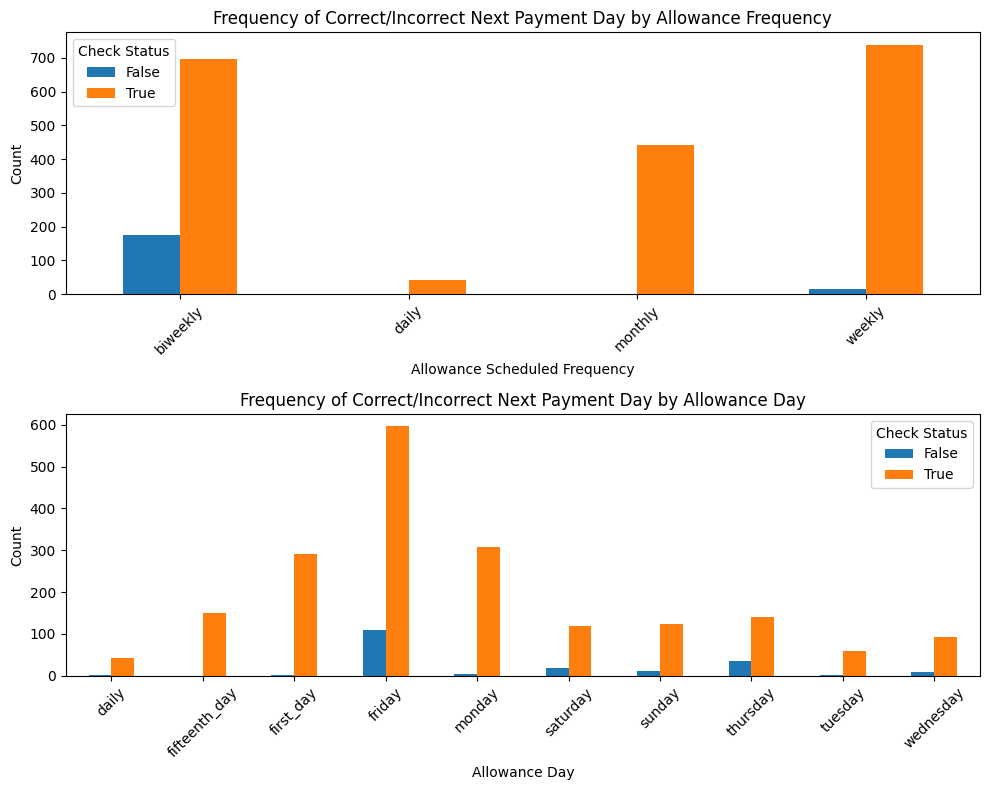

In [27]:
check_pandas = check.toPandas()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# First plot: Frequency of Correct/Incorrect by Allowance Frequency
frequency_counts = check_pandas.groupby(['frequency', 'check']).size().unstack(fill_value=0)
frequency_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Frequency of Correct/Incorrect Next Payment Day by Allowance Frequency')
axes[0].set_xlabel('Allowance Scheduled Frequency')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Check Status')

# Second plot: Frequency of Correct/Incorrect by Allowance Day
frequency_counts = check_pandas.groupby(['day', 'check']).size().unstack(fill_value=0)
frequency_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Frequency of Correct/Incorrect Next Payment Day by Allowance Day')
axes[1].set_xlabel('Allowance Day')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Check Status')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [36]:
rank_graph_df = check.filter("check is false") \
                     .groupBy(to_date("updated_at").alias("updated_date"), "check") \
                     .agg(count("*").alias("false_record_count")) \
                     .drop("check").sort(col("false_record_count").desc())

rank_graph_df.show()

+------------+------------------+
|updated_date|false_record_count|
+------------+------------------+
|  2024-12-02|                16|
|  2024-09-10|                 8|
|  2024-11-25|                 8|
|  2024-11-26|                 7|
|  2024-12-03|                 7|
|  2024-10-09|                 7|
|  2024-11-27|                 6|
|  2024-11-20|                 6|
|  2024-10-01|                 6|
|  2024-10-22|                 5|
|  2024-09-03|                 5|
|  2024-10-07|                 4|
|  2024-11-18|                 4|
|  2024-11-12|                 4|
|  2024-09-02|                 4|
|  2024-11-04|                 4|
|  2024-09-26|                 4|
|  2024-11-06|                 4|
|  2024-09-30|                 4|
|  2024-09-04|                 3|
+------------+------------------+
only showing top 20 rows



# Summary

### Inconsistences:

1. allowance_backend_table contains multiple data types on updated_at column.
3. allowance_backend_table contains outdated users.
4. payment_schedule_backend_table contains more than one record per user_id.
5. Most of the inconsistences from allowance_backend_table are linked to biweekly frequency and linked to Friday.